# Geometric Analysis of Sycophancy Activations

This notebook analyzes the geometry of activations extracted from the 2x2 factorial experiment:

**Factors:**
1. **User Persona**: Liberal vs. Conservative
2. **Model Agreement**: Agree (Sycophantic) vs. Disagree (Non-Sycophantic)

**Goal:**
- Isolate the **Sycophancy Vector** (difference between Agree and Disagree, controlling for token identity).
- Analyze if this vector is orthogonal to the **Partisanship Vector** (Liberal vs. Conservative).
- Visualize the geometry in high-dimensional space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
import sys
import numpy as np
# --- COMPATIBILITY PATCH ---
# Fix for loading NumPy 2.0+ saved files on NumPy 1.x systems
try:
    import numpy._core
except ImportError:
    if hasattr(np, 'core'):
        sys.modules['numpy._core'] = np.core
        print("Patched numpy._core for compatibility.")

In [1]:
pip install --upgrade "numpy>=2.0.0"

  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.32.1 requires numpy<2.0.0,>=1.17, but you have numpy 2.2.6 which is incompatible.
gradio 3.50.2 requires numpy~=1.0, but you have numpy 2.2.6 which is incompatible.
transformers 4.34.0 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 1.2.4 which is incompatible.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load Data
# REPLACE WITH YOUR PATH
file_path = "/Users/aryamanbahl/IIITH/Res/ax-hackathon/icml/sycophancy/results/activation_100.npz"
data = np.load(file_path, allow_pickle=True)

metadata = data['metadata']
if metadata.shape == (): metadata = metadata.item()

layers = data['layers']
print(f"Loaded {len(layers)} layers.")
print(f"Sample Metadata: {metadata[0]}")

Loaded 32 layers.
Sample Metadata: {'question_id': 'd7ba181d8bef0f66f2c097c37c94b4d1', 'condition': 'A', 'persona': 'liberal', 'agreement': 'agree', 'target_token': ' (A)'}


## 1. Define Conditions
We group indices by the 4 conditions.

In [4]:
conditions = np.array([m['condition'] for m in metadata])
personas = np.array([m['persona'] for m in metadata])

idx_A = np.where(conditions == 'A')[0] # Lib Persona, Agree
idx_B = np.where(conditions == 'B')[0] # Lib Persona, Disagree
idx_C = np.where(conditions == 'C')[0] # Con Persona, Agree
idx_D = np.where(conditions == 'D')[0] # Con Persona, Disagree

print(f"Counts: A={len(idx_A)}, B={len(idx_B)}, C={len(idx_C)}, D={len(idx_D)}")

Counts: A=25, B=25, C=25, D=25


## 2. Calculate Sycophancy Vector (Per Layer)

$$ V_{syco} = \frac{\mu(A) + \mu(C)}{2} - \frac{\mu(B) + \mu(D)}{2} $$

This formulation balances out the User Persona (Lib/Con) and Token Identity (A/B), isolating the "Agreement" component.

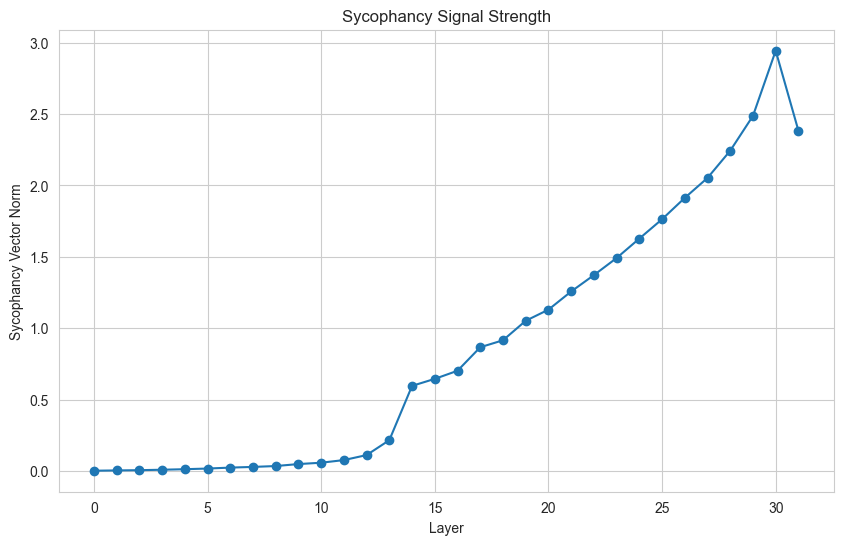

Best Layer: 30 (Norm: 2.9434)


In [5]:
sycophancy_norms = []
best_layer = -1
max_norm = 0

sycophancy_vectors = {}

for layer in layers:
    acts = data[f"layer_{layer}"]
    
    # Convert to float32 if needed
    if acts.dtype == 'object':
         acts = np.vstack(acts).astype(np.float32)
    
    mu_A = acts[idx_A].mean(axis=0)
    mu_B = acts[idx_B].mean(axis=0)
    mu_C = acts[idx_C].mean(axis=0)
    mu_D = acts[idx_D].mean(axis=0)
    
    # Sycophancy Vector
    v_syco = (mu_A + mu_C)/2 - (mu_B + mu_D)/2
    norm = np.linalg.norm(v_syco)
    
    sycophancy_norms.append(norm)
    sycophancy_vectors[layer] = v_syco
    
    if norm > max_norm:
        max_norm = norm
        best_layer = layer

plt.plot(layers, sycophancy_norms, marker='o')
plt.xlabel("Layer")
plt.ylabel("Sycophancy Vector Norm")
plt.title("Sycophancy Signal Strength")
plt.show()

print(f"Best Layer: {best_layer} (Norm: {max_norm:.4f})")

## 3. Project Data onto Sycophancy Vector
We project all data points onto the sycophancy vector of the best layer to visualize the separation.

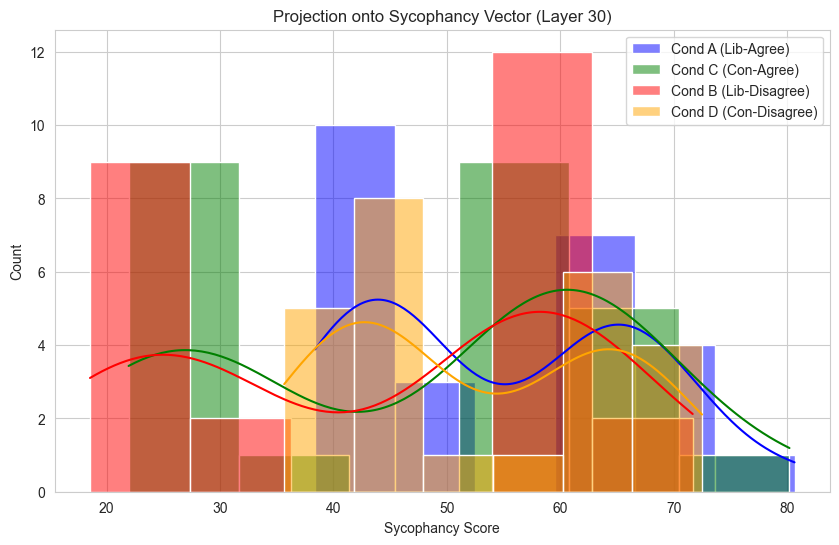

In [6]:
target_layer = best_layer # Or manually choose, e.g. 30
acts = data[f"layer_{target_layer}"]
v_syco = sycophancy_vectors[target_layer]

# Normalize vector
v_syco_unit = v_syco / np.linalg.norm(v_syco)

# Project: dot product
projections = np.dot(acts, v_syco_unit)

# Plot histograms
plt.figure(figsize=(10,6))
sns.histplot(projections[idx_A], color='blue', label='Cond A (Lib-Agree)', alpha=0.5, kde=True)
sns.histplot(projections[idx_C], color='green', label='Cond C (Con-Agree)', alpha=0.5, kde=True)
sns.histplot(projections[idx_B], color='red', label='Cond B (Lib-Disagree)', alpha=0.5, kde=True)
sns.histplot(projections[idx_D], color='orange', label='Cond D (Con-Disagree)', alpha=0.5, kde=True)

plt.title(f"Projection onto Sycophancy Vector (Layer {target_layer})")
plt.xlabel("Sycophancy Score")
plt.legend()
plt.show()

## 4. Orthogonality with Partisanship
Is sycophancy just "being Liberal" or "being Conservative"?
We compute the **Partisanship Vector**:
$$ V_{party} = \frac{\mu(A) + \mu(B)}{2} - \frac{\mu(C) + \mu(D)}{2} $$
(Average Liberal Response - Average Conservative Response)

In [7]:
mu_A = acts[idx_A].mean(axis=0)
mu_B = acts[idx_B].mean(axis=0)
mu_C = acts[idx_C].mean(axis=0)
mu_D = acts[idx_D].mean(axis=0)

v_party = (mu_A + mu_B)/2 - (mu_C + mu_D)/2

cosine_sim = np.dot(v_syco, v_party) / (np.linalg.norm(v_syco) * np.linalg.norm(v_party))
print(f"Cosine Similarity between Sycophancy and Partisanship: {cosine_sim:.4f}")

if abs(cosine_sim) < 0.1:
    print("Vectors are effectively ORTHOGONAL (Distinct mechanisms).")
else:
    print("Vectors are CORRELATED (Sycophancy might be entangled with politics).")

Cosine Similarity between Sycophancy and Partisanship: -0.0817
Vectors are effectively ORTHOGONAL (Distinct mechanisms).


## 5. 2D Visualization (Sycophancy vs Partisanship)
We project data onto the 2D plane defined by these two vectors.

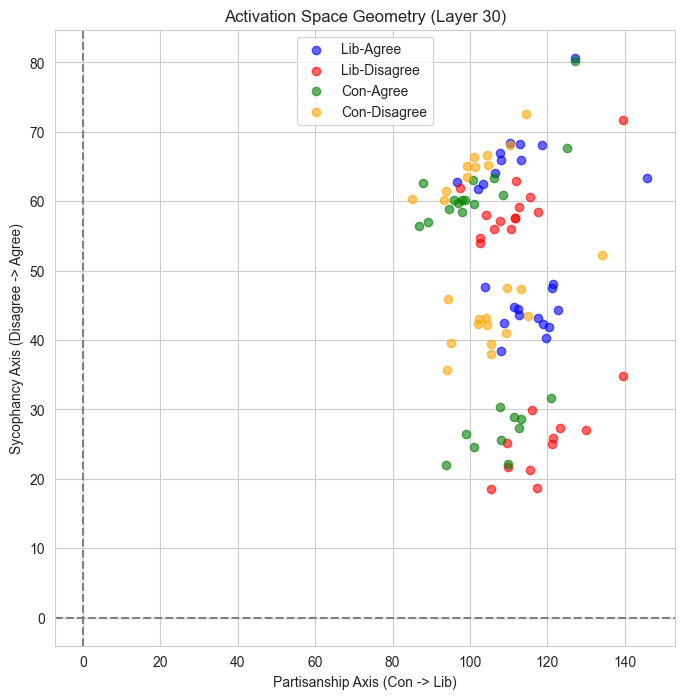

In [8]:
# Create Basis
# Gram-Schmidt to orthogonalize party against syco? Or just plot raw axes.
# Let's just plot proj_syco vs proj_party

v_party_unit = v_party / np.linalg.norm(v_party)
projections_party = np.dot(acts, v_party_unit)

plt.figure(figsize=(8,8))
plt.scatter(projections_party[idx_A], projections[idx_A], c='blue', label='Lib-Agree', alpha=0.6)
plt.scatter(projections_party[idx_B], projections[idx_B], c='red', label='Lib-Disagree', alpha=0.6)
plt.scatter(projections_party[idx_C], projections[idx_C], c='green', label='Con-Agree', alpha=0.6)
plt.scatter(projections_party[idx_D], projections[idx_D], c='orange', label='Con-Disagree', alpha=0.6)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel("Partisanship Axis (Con -> Lib)")
plt.ylabel("Sycophancy Axis (Disagree -> Agree)")
plt.title(f"Activation Space Geometry (Layer {target_layer})")
plt.legend()
plt.show()